# 从零实现线性回归-实操笔记

In [1]:
%matplotlib inline
import random as rd
import torch as tor
from d2l import torch as d2l_tor

导个库先

## 第0步：人造数据集

根据带有噪声的线性模型构造一个人造数据集
$$ y = Xw + b + \epsilon $$
- y：生成的数据
- X：产生的随机数据
- w：线性系数$[2,-3.4]^T$
- b：常数系数4.2
- $\epsilon$：噪声项

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 [y = Xw + b + 噪声] 的模型"""
    X = tor.normal(0, 1, (num_examples, len(w)))      # 均值为0，方差为1
    '''
    结构展示：
    [X01w_1, X01w_2, X01w_3, ……X01w_n]_1
    [X01w_1, X01w_2, X01w_3, ……X01w_n]_2
    [X01w_1, X01w_2, X01w_3, ……X01w_n]_2
    ……
    [X01w_1, X01w_2, X01w_3, ……X01w_n]_num_examples
    '''
    y = tor.matmul(X, w) + b                          # torch的matmul是缩小维度的会转化为列数组会把多空间相加
    y += tor.normal(0, 0.01, y.shape)                 # 均值为0，方差为0.01
    return X, y.reshape((-1, 1)) # -1是指数据的长度就是前面组的小坐标为例也就是所谓的依据数组长度子那个由大小配比决定

true_w = tor.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [3]:
len(true_w)

2

In [4]:
print('features_0:', features[0], '\nlabel_0[y]:', labels[0])
print('\ny.shape:', labels.shape)

features_0: tensor([-1.8567, -0.7807]) 
label_0[y]: tensor([3.1358])

y.shape: torch.Size([1000, 1])


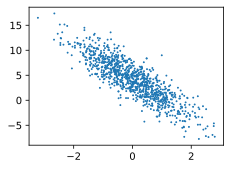

In [5]:
d2l_tor.set_figsize() # 首先是去创建一个图(类似于matlab的figure)
d2l_tor.plt.scatter(features[:, 1].detach().numpy(),
                    labels.detach().numpy(), 1); # 这里的detach是用于数据的展平，将一个带维度数据展平为一个数字，labels同理，当然numpy是爹直接展平为大家·都喜欢的数据

## 第1步：转化为小批量

定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量(y)为输入，生成大小为batch_size的小批量，让python批量化的处理

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))                      # 创建一个由features为总集合及逆行随机抽取组成的列表，range范围列出列表
    rd.shuffle(indices)                                      # 进行随机取数字分配
    for i in range(0, num_examples, batch_size):
        batch_indices = tor.tensor(
            indices[i:min(i + batch_size, num_examples)])    # 我们在这里可以发现一个min作用是我们将我们搞到的数字做一个取值，如果数据可以足够批次，那就按批取，如果少了(指最后一批)那就那就去找最高吧
        yield features[batch_indices], labels[batch_indices] # 你可以将yield看作是一个生成器，其实就是说他是一个输出一组数字

batch_size = 10;

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break;

print('\nX.shape:', X.shape)
print('y.shape:', y.shape)

tensor([[-1.1722, -0.1526],
        [-2.0475,  1.3200],
        [ 1.0040, -1.2306],
        [-0.7931,  0.7565],
        [ 0.4081, -1.6358],
        [-0.0802, -0.6663],
        [-0.1719,  0.1094],
        [ 0.0813, -1.0205],
        [-0.9863, -0.3241],
        [-0.2931,  0.0599]]) 
 tensor([[ 2.3775],
        [-4.3925],
        [10.3999],
        [ 0.0478],
        [10.5813],
        [ 6.3197],
        [ 3.4699],
        [ 7.8341],
        [ 3.3381],
        [ 3.3965]])

X.shape: torch.Size([10, 2])
y.shape: torch.Size([10, 1])


## 第2步：制作模型

其实就是我们需要对于我们的问题提出一个函数表达式，我们取构建一个函数来求解我们的问题，只不过这个函数的参数是我们采用电脑去对我们的数据求解

### 定义 初始化模型参数

我们首先要进行一些参数的初始化，说白了也是建立模型的一部分罢了

In [7]:
w = tor.normal(0, 0.01, size=(2, 1), requires_grad=True) # 设定一个系数参考(初始值)，但是要求导所以求导参数化为True【但这里为什么不是size=(1,2)匹配输入】
b = tor.zeros(1, requires_grad=True)                     # 设定一个常数参考(初始值)，但是要求导所以求导参数化为True

### 定义 模型

依据自己猜想的数学式子定义模型

In [8]:
def linreg(X, w, b):
    """线性回归模型--依据上面的人造数据集做猜想,当然现实中是自己定义,你也不知道那个数学式子是什么"""
    return tor.matmul(X, w) + b

### 定义 损失函数

In [9]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 # 除以2是为了求导消系数【x^2求导2x】

### 定义 优化算法

In [10]:
def sgd(params, lr, batch_size):                  # param是参数表 lr 是学习率 batch_size 是池化批量
    """小批量随机梯度下降"""
    with tor.no_grad():                           # 在没有求导时，保证了跟新不会被计算,因为在这个函数之前是算过了backward和sum的所以这里没有做
        for param in params:
            param -= lr * param.grad / batch_size # 求了均值
            param.grad.zero_()                    # 归0梯度放置被累加

优化算法有很多，其实原理就是依据某一个指标进行的特化"强调"罢了，这里使用no_grad的作用是使得没有东西在求导，保证了前一代数据的完整性

### 训练过程

In [11]:
lr = 0.03 # 学习率
num_epochs = 3 # 数据重复扫描次数(完整数据的扫描)
net = linreg   # 这是一种python的用法是python view的延伸，其实就是给函数名取别名，这个在lua中也是有使用的，方便我们换模型
loss = squared_loss # 同是一个批注，其实就是函数的别名指代，并且方便替换，说起来感觉还有点泛用化便车给的感觉

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 'X' 和 'y' 的小批量损失
        # 因为'l'的形状是('batch_size', 1)，而不是一个标量。所以将'l'中的所有元素进行加和再进行反向传播，更快更便捷并且也符合自动优化方法
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数更新自动进行更新
    with tor.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')


epoch1, loss0.034233
epoch2, loss0.000122
epoch3, loss0.000049


### 真实与训练进行比较(由于我们是人造数据集所以可以肆无忌惮的分析)

真实数据与训练出的模型进行比较进行评估

In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-3.8862e-05,  5.9462e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([9.1553e-05], grad_fn=<RsubBackward1>)
